In [1]:
import numpy as np
import sys
import h5py
import os
import tensorflow as tf
from tensorflow.keras.optimizers import Adagrad, Ftrl
import matplotlib.pyplot as plt
import pandas as pd

sys.path.append("..")
from cryoem.angle_alignment import training_angle_alignment
from cryoem.conversions import quaternion2euler, d_q, euler2quaternion
from cryoem.angle_alignment import training_angle_alignment, update_quaternion
from cryoem.plots import plot_dP_dQ


import seaborn as sns; sns.set(style="whitegrid", color_codes=True)


In [2]:
cmap=plt.get_cmap('tab10')

In [3]:
TRAIN_COLOR = cmap(2)
VAL_COLOR = cmap(1)
TEST_COLOR_LOR = cmap(0)
TEST_COLOR_EOR = cmap(3)

In [4]:
from numba import cuda
cuda.select_device(0)
cuda.close()

In [5]:
ROOT_DIR = ".."
NUM_PROJECTIONS = 5000
DATA_DIR = "../data/publication_plots_data"

In [6]:
PROTEIN="5j0n"

projections_filename = f"{PROTEIN}_ProjectionsAngles_ProjNber5000_AngCoverage2.0,0.4,2.0_AngShift0.0,0.0,0.0.h5"

data = h5py.File(os.path.join(DATA_DIR, projections_filename), 'r')

angles_true = data['Angles']

In [7]:
# projections = data['Projections']
# angles_true = np.array(data['Angles'])
# projections.shape, angles_true.shape

In [8]:
data = np.load(f"{DATA_DIR}/5j0n_siamese_idx.npz")
train_idx, val_idx, test_idx = data["arr_0"], data["arr_1"], data["arr_2"]

In [9]:
tick_size=15
label_size=15
labelpad = 20
fontsize = 20

---

## Learning from Noisy Projections

In [10]:
tick_size = 18
label_size = 20

textbox_size=14.3
small_text = 10

In [11]:
df0_train = pd.read_csv(f"{DATA_DIR}/run-noisy_var0_train-tag-epoch_loss.csv")
df0_train["noise_variance"] = df0_train.apply(lambda x: 0, axis=1)
df0_train["dataset"] = df0_train.apply(lambda x: "train", axis=1)

df0_val = pd.read_csv(f"{DATA_DIR}/run-noisy_var0_validation-tag-epoch_loss.csv")
df0_val["noise_variance"] = df0_val.apply(lambda x: 0, axis=1)
df0_val["dataset"] = df0_val.apply(lambda x: "validation", axis=1)

df5_train = pd.read_csv(f"{DATA_DIR}/run-noisy_var5_train-tag-epoch_loss.csv")
df5_train["noise_variance"] = df5_train.apply(lambda x: 5, axis=1)
df5_train["dataset"] = df5_train.apply(lambda x: "train", axis=1)

df5_val = pd.read_csv(f"{DATA_DIR}/run-noisy_var5_validation-tag-epoch_loss.csv")
df5_val["noise_variance"] = df5_val.apply(lambda x: 5, axis=1)
df5_val["dataset"] = df5_val.apply(lambda x: "validation", axis=1)

df10_train = pd.read_csv(f"{DATA_DIR}/run-noisy_var10_train-tag-epoch_loss.csv")
df10_train["noise_variance"] = df10_train.apply(lambda x: 10, axis=1)
df10_train["dataset"] = df10_train.apply(lambda x: "train", axis=1)

df10_val = pd.read_csv(f"{DATA_DIR}/run-noisy_var10_validation-tag-epoch_loss.csv")
df10_val["noise_variance"] = df10_val.apply(lambda x: 10, axis=1)
df10_val["dataset"] = df10_val.apply(lambda x: "validation", axis=1)

df14_train = pd.read_csv(f"{DATA_DIR}/run-noisy_var14_train-tag-epoch_loss.csv")
df14_train["noise_variance"] = df14_train.apply(lambda x: 16, axis=1)
df14_train["dataset"] = df14_train.apply(lambda x: "train", axis=1)

df14_val = pd.read_csv(f"{DATA_DIR}/run-noisy_var14_validation-tag-epoch_loss.csv")
df14_val["noise_variance"] = df14_val.apply(lambda x: 16, axis=1)
df14_val["dataset"] = df14_val.apply(lambda x: "validation", axis=1)

df20_train = pd.read_csv(f"{DATA_DIR}/run-noisy_var20_train-tag-epoch_loss.csv")
df20_train["noise_variance"] = df20_train.apply(lambda x: 20, axis=1)
df20_train["dataset"] = df20_train.apply(lambda x: "train", axis=1)

df20_val = pd.read_csv(f"{DATA_DIR}/run-noisy_var20_validation-tag-epoch_loss.csv")
df20_val["noise_variance"] = df20_val.apply(lambda x: 20, axis=1)
df20_val["dataset"] = df20_val.apply(lambda x: "validation", axis=1)

df25_train = pd.read_csv(f"{DATA_DIR}/run-noisy_var25_train-tag-epoch_loss.csv")
df25_train["noise_variance"] = df25_train.apply(lambda x: 25, axis=1)
df25_train["dataset"] = df25_train.apply(lambda x: "train", axis=1)

df25_val = pd.read_csv(f"{DATA_DIR}/run-noisy_var25_validation-tag-epoch_loss.csv")
df25_val["noise_variance"] = df25_val.apply(lambda x: 25, axis=1)
df25_val["dataset"] = df25_val.apply(lambda x: "validation", axis=1)

In [12]:
df = pd.concat([eval(f"df{i}_{d}") for i in [0, 5, 10, 14, 20, 25] for d in ["train", "val"]])

In [13]:
df.dataset.unique()

array(['train', 'validation'], dtype=object)

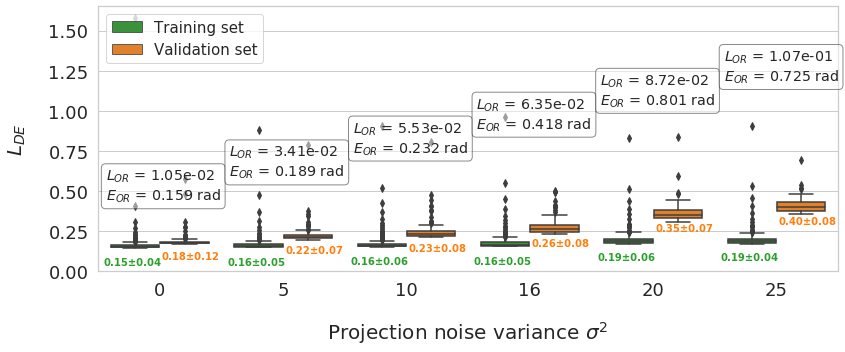

In [14]:
fig, ax = plt.subplots(figsize=(12,5))

df["dataset_full"] = df.dataset.apply(lambda x: "Training set" if x=="train" else "Validation set" if x=="validation" else x)

mapping = {0:0, 1:5, 2:10, 3:16, 4:20, 5:25}
color_map  = {"Training set": TRAIN_COLOR, "Validation set": VAL_COLOR, "": "k"}

box_plot = sns.boxplot(x="noise_variance", y="Value", hue="dataset_full", data=df, ax=ax, palette=color_map)
box_plot.tick_params(labelsize=tick_size)
ax.set_xlabel("Projection noise variance $\sigma^2$ ", fontsize=label_size, labelpad=labelpad);
ax.set_ylabel("$L_{DE}$", fontsize=label_size, labelpad=labelpad);
ax.set_ylim(0)
ax.legend(loc=2, fontsize=15)

medians_na = df[df.dataset=='train'].groupby(['noise_variance'])['Value'].median()#.sort_values(ascending=False)
stds_na = df[df.dataset=='train'].groupby(['noise_variance'])['Value'].std()
vertical_offset_na = df[df.dataset=='train']['noise_variance'].median() * 0.009 # offset from median for display
horizontal_offset_na = 0.25

medians = df[df.dataset=='validation'].groupby(['noise_variance'])['Value'].median()#.sort_values(ascending=False)
stds = df[df.dataset=='validation'].groupby(['noise_variance'])['Value'].std()
vertical_offset = df[df.dataset=='validation']['noise_variance'].median() * 0.008 # offset from median for display
horizontal_offset = 0.22

props_red = dict(boxstyle='round', facecolor=TEST_COLOR_EOR, alpha=0.0)
props_blue = dict(boxstyle='round', facecolor=TEST_COLOR_LOR, alpha=0.0)
props = dict(boxstyle='round', edgecolor=TEST_COLOR_LOR, alpha=1.)

Es = [0.1594, 0.1893, 0.2315, 0.4184, 0.8012, 0.7251]
ARs = [1.05e-02, 3.41e-02, 5.53e-02, 6.35e-02, 8.72e-02, 1.07e-01]

for xtick in box_plot.get_xticks():
    box_plot.text(xtick+horizontal_offset_na, 
                  medians[mapping[xtick]] - vertical_offset, 
                  f"{medians[mapping[xtick]]:.2f}±{stds_na[mapping[xtick]]:.2f}", 
                  horizontalalignment='center', 
                  size='x-small', weight='semibold', fontsize=small_text, color=VAL_COLOR)
    #print(xtick)
    
    ret_val = "$L_{OR}$ = "+f"{ARs[xtick]:.2e}" + "\n$E_{OR}$ = "+f"{Es[xtick]:.3f} rad"
    #box_plot.text(0.03+xtick*0.163, 0.3+xtick*0.08, "$L_{OR}$ = "+f"{ARs[xtick]:.2e}", transform=ax.transAxes, fontsize=17, verticalalignment='top', bbox=props_blue)
    #box_plot.text(0.03+xtick*0.163, 0.37+xtick*0.08, "$E_{OR}$ = "+f"{Es[xtick]:.3f} rad", transform=ax.transAxes, fontsize=17, verticalalignment='top', bbox=props_red)
    #box_plot.text(0.03+xtick*0.163, 0.37+xtick*0.08, "", transform=ax.transAxes, fontsize=17, verticalalignment='top', bbox=props)
    #r = plt.Rectangle((-0.37+xtick*0.98, 0.4+xtick*0.13), 0.96, 0.25, facecolor="black", alpha=0.1)
    #ax.add_patch(r)
    box_plot.text(0.01+xtick*0.167, 0.39+xtick*0.09, ret_val,
              #ha="center",
              size=textbox_size,
              verticalalignment='top',
              transform=ax.transAxes,
              bbox=dict(boxstyle="round", fc="w", ec="k", alpha=0.5))

for xtick in box_plot.get_xticks():
    box_plot.text(xtick-horizontal_offset, 
                  medians_na[mapping[xtick]] - vertical_offset_na, 
                  f"{medians_na[mapping[xtick]]:.2f}±{stds[mapping[xtick]]:.2f}", 
                  horizontalalignment='center', 
                  size='x-small', weight='semibold', fontsize=small_text, color=TRAIN_COLOR)

plt.tight_layout()
plt.savefig("pdfs/de_noises_nums.pdf")
plt.show()

---

## Learning from Shifted Projections

In [15]:
tick_size = 18
label_size = 20

textbox_size=16
small_text = 10

In [16]:
df0_train = pd.read_csv(f"{DATA_DIR}/run-noisy_var0_train-tag-epoch_loss.csv")
df0_train["translation"] = df0_train.apply(lambda x: 0, axis=1)
df0_train["dataset"] = df0_train.apply(lambda x: "train", axis=1)
#df0_train = df0_train[df0_train.Step<100]

df0_val = pd.read_csv(f"{DATA_DIR}/run-noisy_var0_validation-tag-epoch_loss.csv")
df0_val["translation"] = df0_val.apply(lambda x: 0, axis=1)
df0_val["dataset"] = df0_val.apply(lambda x: "validation", axis=1)
#df0_val = df0_val[df0_val.Step<100]

df5_train = pd.read_csv(f"{DATA_DIR}/run-translation5_train-tag-epoch_loss.csv")
df5_train["translation"] = df5_train.apply(lambda x: 5, axis=1)
df5_train["dataset"] = df5_train.apply(lambda x: "train", axis=1)

df5_val = pd.read_csv(f"{DATA_DIR}/run-translation5_validation-tag-epoch_loss.csv")
df5_val["translation"] = df5_val.apply(lambda x: 5, axis=1)
df5_val["dataset"] = df5_val.apply(lambda x: "validation", axis=1)

df10_train = pd.read_csv(f"{DATA_DIR}/run-translation10_train-tag-epoch_loss.csv")
df10_train["translation"] = df10_train.apply(lambda x: 10, axis=1)
df10_train["dataset"] = df10_train.apply(lambda x: "train", axis=1)

df10_val = pd.read_csv(f"{DATA_DIR}/run-translation10_validation-tag-epoch_loss.csv")
df10_val["translation"] = df10_val.apply(lambda x: 10, axis=1)
df10_val["dataset"] = df10_val.apply(lambda x: "validation", axis=1)

df14_train = pd.read_csv(f"{DATA_DIR}/run-translation15_train-tag-epoch_loss.csv")
df14_train["translation"] = df14_train.apply(lambda x: 16, axis=1)
df14_train["dataset"] = df14_train.apply(lambda x: "train", axis=1)

df14_val = pd.read_csv(f"{DATA_DIR}/run-translation15_validation-tag-epoch_loss.csv")
df14_val["translation"] = df14_val.apply(lambda x: 16, axis=1)
df14_val["dataset"] = df14_val.apply(lambda x: "validation", axis=1)

df20_train = pd.read_csv(f"{DATA_DIR}/run-translation20_train-tag-epoch_loss.csv")
df20_train["translation"] = df20_train.apply(lambda x: 20, axis=1)
df20_train["dataset"] = df20_train.apply(lambda x: "train", axis=1)

df20_val = pd.read_csv(f"{DATA_DIR}/run-translation20_validation-tag-epoch_loss.csv")
df20_val["translation"] = df20_val.apply(lambda x: 20, axis=1)
df20_val["dataset"] = df20_val.apply(lambda x: "validation", axis=1)

In [17]:
df = pd.concat([eval(f"df{i}_{d}") for i in [0, 5, 10, 14, 20] for d in ["train", "val"]])

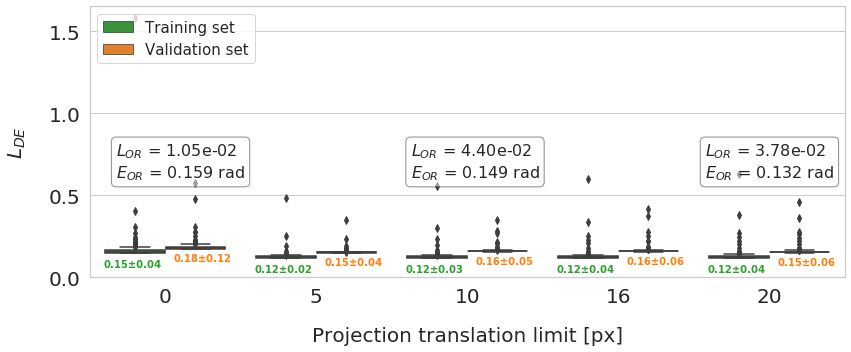

In [18]:
fig, ax = plt.subplots(figsize=(12,5))

df["dataset_full"] = df.dataset.apply(lambda x: "Training set" if x=="train" else "Validation set" if x=="validation" else x)

mapping = {0:0, 1:5, 2:10, 3:16, 4:20}
color_map  = {"Training set": TRAIN_COLOR, "Validation set": VAL_COLOR, "": "k"}

box_plot = sns.boxplot(x="translation", y="Value", hue="dataset_full", data=df, ax=ax, palette=color_map)
box_plot.tick_params(labelsize=20)
ax.set_xlabel("Projection translation limit [px]", fontsize=label_size, labelpad=labelpad);
ax.set_ylabel("$L_{DE}$", fontsize=label_size, labelpad=labelpad);
ax.set_ylim(0)
ax.legend(loc=2, fontsize=15)

medians_na = df[df.dataset=='train'].groupby(['translation'])['Value'].median()#.sort_values(ascending=False)
stds_na = df[df.dataset=='train'].groupby(['translation'])['Value'].std()
vertical_offset_na = df[df.dataset=='train']['translation'].median() * 0.009 # offset from median for display
horizontal_offset_na = 0.25

medians = df[df.dataset=='validation'].groupby(['translation'])['Value'].median()#.sort_values(ascending=False)
stds = df[df.dataset=='validation'].groupby(['translation'])['Value'].std()
vertical_offset = df[df.dataset=='validation']['translation'].median() * 0.008 # offset from median for display
horizontal_offset = 0.22

props_red = dict(boxstyle='round', facecolor=TEST_COLOR_EOR, alpha=0.5)
props_blue = dict(boxstyle='round', facecolor=TEST_COLOR_LOR, alpha=0.5)

Es =  [0.1594,   0.0, 0.14933, 0.0, 0.13211]
ARs = [1.05e-02, 0.0, 0.044,   0.0, 0.0378]

for xtick in box_plot.get_xticks():
    box_plot.text(xtick+horizontal_offset_na, 
                  medians[mapping[xtick]] - vertical_offset, 
                  f"{medians[mapping[xtick]]:.2f}±{stds_na[mapping[xtick]]:.2f}", 
                  horizontalalignment='center', 
                  size='x-small', weight='semibold', fontsize=small_text, color=VAL_COLOR)
    if xtick not in [1, 3]:
        #box_plot.text(0.05+xtick*0.195, 0.3+0.08, "$L_{OR}$ = "+f"{ARs[xtick]:.2e}", transform=ax.transAxes, fontsize=17, verticalalignment='top', bbox=props_blue)
        #box_plot.text(0.05+xtick*0.195, 0.37+0.08, "$E_{OR}$ = "+f"{Es[xtick]:.3f} rad", transform=ax.transAxes, fontsize=17, verticalalignment='top', bbox=props_red)
        ret_val = "$L_{OR}$ = "+f"{ARs[xtick]:.2e}" + "\n$E_{OR}$ = "+f"{Es[xtick]:.3f} rad"
        #box_plot.text(0.03+xtick*0.163, 0.3+xtick*0.08, "$L_{OR}$ = "+f"{ARs[xtick]:.2e}", transform=ax.transAxes, fontsize=17, verticalalignment='top', bbox=props_blue)
        #box_plot.text(0.03+xtick*0.163, 0.37+xtick*0.08, "$E_{OR}$ = "+f"{Es[xtick]:.3f} rad", transform=ax.transAxes, fontsize=17, verticalalignment='top', bbox=props_red)
        #box_plot.text(0.03+xtick*0.163, 0.37+xtick*0.08, "", transform=ax.transAxes, fontsize=17, verticalalignment='top', bbox=props)
        #r = plt.Rectangle((-0.37+xtick*0.98, 0.4+xtick*0.13), 0.96, 0.25, facecolor="black", alpha=0.1)
        #ax.add_patch(r)
        box_plot.text(0.035+xtick*0.195, 0.42+0.08, ret_val,
                  #ha="center",
                  size=textbox_size,
                  verticalalignment='top',
                  transform=ax.transAxes,
                  bbox=dict(boxstyle="round", fc="w", ec="k", alpha=0.5))

for xtick in box_plot.get_xticks():
    box_plot.text(xtick-horizontal_offset, 
                  medians_na[mapping[xtick]] - vertical_offset_na, 
                  f"{medians_na[mapping[xtick]]:.2f}±{stds[mapping[xtick]]:.2f}", 
                  horizontalalignment='center', 
                  size='x-small', weight='semibold', fontsize=small_text, color=TRAIN_COLOR)
plt.tight_layout()
plt.savefig("pdfs/de_translation_nums.pdf")
plt.show()

---

## $L_{OR}$ and $E_{OR}$ w.r.t. Variance of Noise in `5j0n`

In [19]:
labelpad = 6

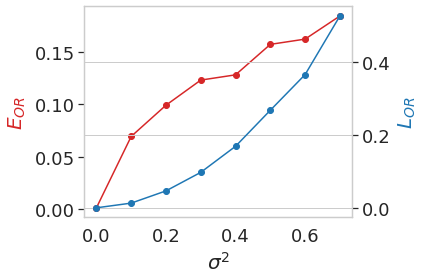

In [20]:
variances = [0.0, 
             0.1, 
             0.2, 
             0.3, 
             0.4, 
             0.5, 
             0.6, 
             0.7, 
             #0.8
            ]
losses = np.array([9.26e-09, 
                   1.29e-02, 
                   4.65e-02, 
                   9.74e-02, 
                   1.69e-01, 
                   2.68e-01, 
                   3.66e-01, 
                   5.27e-01, 
                   #6.39e-01
                  ])
# mean
#aa_losses = np.array([2.49e-03, 7.23e-02, 1.06e-01, 1.26e-01, 1.45e-01, 1.62e-01, 1.80e-01, 1.88e-01, 2.04e-1])
# median
aa_losses = np.array([1.47e-03, 
                      6.94e-02, 
                      9.91e-02, 
                      1.23e-01, 
                      1.28e-01, 
                      1.57e-01, 
                      1.62e-01, 
                      1.84e-01, 
                      #1.94e-01
                     ])
#tick_size=15

#label_size = 20

fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.set_xlabel('$\sigma^2$', fontsize=label_size, labelpad=labelpad)
ax.plot(variances, aa_losses, marker="o", color=TEST_COLOR_EOR)
ax.set_ylabel('$E_{OR}$', color=TEST_COLOR_EOR, fontsize=label_size, labelpad=labelpad)
plt.tick_params(axis='both', which='major', labelsize=tick_size)
ax.grid()

ax2 = ax.twinx()
ax2.plot(variances, losses, marker="o", color=TEST_COLOR_LOR)
ax2.set_ylabel('$L_{OR}$', color=TEST_COLOR_LOR, fontsize=label_size, labelpad=labelpad)
ax2.tick_params(axis='both', which='major', labelsize=tick_size)

plt.tight_layout()
plt.savefig("pdfs/5j0n_perfect_noisy_ar_aa.pdf")
plt.show()

## $L_{OR}$ and $E_{OR}$ w.r.t. Variance of Noise in `5a1a`

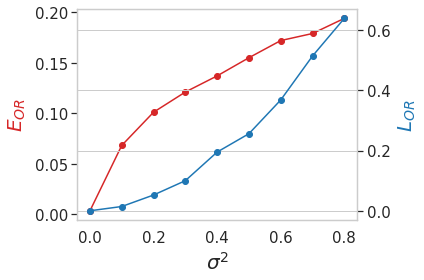

In [21]:

# losses
variances = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
losses = np.array([1.42e-08, 1.42e-02, 5.24e-02, 1.00e-01, 1.95e-01, 2.56e-01, 3.68e-01, 5.14e-01, 6.39e-01])
# mean
#aa_losses = np.array([2.49e-03, 7.23e-02, 1.06e-01, 1.26e-01, 1.45e-01, 1.62e-01, 1.80e-01, 1.88e-01, 2.04e-1])
# median
aa_losses = np.array([3.33e-03, 6.81e-02, 1.01e-01, 1.21e-01, 1.37e-01, 1.55e-01, 1.72e-01, 1.79e-01, 1.94e-01])

tick_size=15
#labelpad = 20
#label_size = 20

fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.set_xlabel('$\sigma^2$', fontsize=label_size, labelpad=labelpad)
ax.plot(variances, aa_losses, marker="o", color=TEST_COLOR_EOR)
ax.set_ylabel('$E_{OR}$', color=TEST_COLOR_EOR, fontsize=label_size, labelpad=labelpad)
plt.tick_params(axis='both', which='major', labelsize=tick_size)
ax.grid()

ax2 = ax.twinx()
ax2.plot(variances, losses, marker="o", color=TEST_COLOR_LOR)
ax2.set_ylabel('$L_{OR}$', color=TEST_COLOR_LOR, fontsize=label_size, labelpad=labelpad)
ax2.tick_params(axis='both', which='major', labelsize=tick_size)

plt.tight_layout()
plt.savefig("pdfs/5a1a_perfect_noisy_ar_aa.pdf")
plt.show()

---

## $\frac{d_p}{d_q}$ plot for the `5j0n`

In [22]:
# PROTEIN="5j0n"
# ROOT_DIR = "../.."
# NUM_PROJECTIONS = 5000

# # location of *.h5 files
# #data_dir = "/mnt/scratch/students/"

# # half coverage (AngCoverage=0.5)
# projections_filename = f"{PROTEIN}_ProjectionsAngles_ProjNber5000_AngCoverage2.0,0.4,2.0_AngShift0.0,0.0,0.0.h5"

# # load structures
# data = h5py.File(os.path.join(DATA_DIR, projections_filename), 'r')

# print(f"{data['Projections'].shape[0]} projections of images with dimension {data['Projections'].shape[1:]} pixels")
# print(f"{data['Angles'].shape[0]} sets of {data['Angles'].shape[1]} ground truth angles of corresponding projection images")

# projections = data['Projections']
# projections.shape

# angles_true = np.array(data['Angles'])
# angles_true.shape

In [23]:
# from skimage.transform import resize

# def rescale_image(image):
#     c = image.shape[-1]/117
#     image_resized = resize(image, (image.shape[0] // c, image.shape[1] // c), anti_aliasing=True)
#     return image_resized

In [24]:
# projections_new = []
# for p in projections:
#     projections_new.append(rescale_image(p))
# projections_new = np.array(projections_new)
# projections_new.shape

In [25]:
# def global_standardization(X):
#     """Does not have all the positive piels
#     Ref: https://machinelearningmastery.com/how-to-manually-scale-image-pixel-data-for-deep-learning/""" 
#     print(f'Image shape: {X[0].shape}')
#     print(f'Data Type: {X[0].dtype}')
#     X = X.astype('float32')

#     print("***")
#     ## GLOBAL STANDARDIZATION
#     # calculate global mean and standard deviation
#     mean, std = X.mean(), X.std()
#     print(f'Mean: {mean:.3f} | Std: {std:.3f}')
#     print(f'Min:  {X.min():.3f} | Max: {X.max():.3f}')
#     # global standardization of pixels
#     X = (X - mean) / std
#     # confirm it had the desired effect
#     mean, std = X.mean(), X.std()
#     print(f'Mean: {mean:.3f} | Std: {std:.3f}')
#     print(f'Min:  {X.min():.3f} | Max: {X.max():.3f}')
    
#     return X


In [26]:
# X, y = np.array(projections_new, dtype=np.float32), np.array(angles_true, dtype=np.float32)

# X = global_standardization(X)

# channels = "gray"
# if channels == "rgb":
#     X = np.stack((X,)*3, axis=-1)
# elif channels == "gray":
#     X = X[:,:,:,np.newaxis]

In [27]:
# model_filename = f"{DATA_DIR}/noisy_var0.h5"

# # Recreate the exact same model, including its weights and the optimizer
# model = tf.keras.models.load_model(model_filename)

# # Show the model architecture
# model.summary()

In [28]:
# from cryoem.conversions import d_q, euler2quaternion


In [29]:
# def d_p(p1, p2):
#     p1 = tf.cast(p1, dtype=tf.float32)
#     p2 = tf.cast(p2, dtype=tf.float32)
#     return model.predict([p1, p2], batch_size=512)

In [30]:
# batch_size = 1024
# idx1 = list(np.random.choice(test_idx, size=batch_size))
# idx2 = list(np.random.choice(test_idx, size=batch_size))

# q1_true = euler2quaternion([angles_true[i] for i in idx1])
# q2_true = euler2quaternion([angles_true[i] for i in idx2])

# p1 = [X[i] for i in idx1]
# p2 = [X[i] for i in idx2]

# dP_values = d_p(p1, p2).T[0]
# dQ_values = d_q(q1_true, q2_true).numpy()

In [31]:
# dP_values

In [32]:
# dQ_values

In [33]:
# #plt.clf()
# # Creating the dataframe for SNS plot
# data = {"d_Q" : dQ_values, #tr_y.numpy(),
#         "d_P" : dP_values } #y_tr_pred.T[0]}
# df1 = pd.DataFrame(data=data)

In [34]:
# df1.head()

In [35]:
# df1.to_csv(f"{DATA_DIR}/dP_dQ_5j0n.csv", index=False)

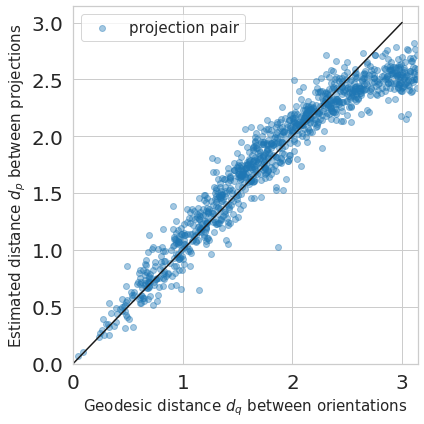

In [36]:
df1 = pd.read_csv(f"{DATA_DIR}/dP_dQ_5j0n.csv")

# Creating the dataframe for SNS plot
# data = {"d_Q" : val_y.numpy(),
#         "d_P" : y_val_pred.T[0]}
# df2 = pd.DataFrame(data=data)

#plt.clf();
fig, ax = plt.subplots(figsize=(6,6));
plt.scatter(df1["d_Q"], df1["d_P"], color=TEST_COLOR_LOR, alpha=0.4, label="projection pair");  # "reg", "kde"
#sns.jointplot(x="d_Q", y="d_P", data=df1, color="b", alpha=0.3, label="projection pair", kind="kde", ax=ax[1]);  # "reg", "kde"
x = np.arange(0, np.pi);
plt.plot(x, x, color="k")
ax.set_xlim(0, np.pi)
ax.set_ylim(0, np.pi)
plt.xlabel("Geodesic distance $d_q$ between orientations", fontsize=tick_size)
plt.ylabel("Estimated distance $d_p$ between projections", fontsize=tick_size)
plt.tick_params(axis='both', which='major', labelsize=label_size)
plt.legend(loc=2, fontsize=15)
plt.tight_layout()
#plt.savefig("pdfs/dPdQ_5j0n.pdf", pad_inches=1)
plt.show();

---

## $\frac{d_p}{d_q}$ plot for the `5a1a`

In [37]:
# PROTEIN="5a1a"
# NUM_PROJECTIONS = 5000


# # half coverage (AngCoverage=0.5)
# projections_filename = f"{PROTEIN}_ProjectionsAngles_ProjNber5000_AngCoverage2.0,1.0,0.5_AngShift0.0,0.0,0.0.h5"

# # load structures
# data = h5py.File(os.path.join(DATA_DIR, projections_filename), 'r')

# print(f"{data['Projections'].shape[0]} projections of images with dimension {data['Projections'].shape[1:]} pixels")
# print(f"{data['Angles'].shape[0]} sets of {data['Angles'].shape[1]} ground truth angles of corresponding projection images")

# projections = data['Projections']
# projections.shape

# angles_true = np.array(data['Angles'])
# angles_true.shape

# from skimage.transform import resize

# def rescale_image(image):
#     c = image.shape[-1]/117
#     image_resized = resize(image, (image.shape[0] // c, image.shape[1] // c), anti_aliasing=True)
#     return image_resized

# projections_new = []
# for p in projections:
#     projections_new.append(rescale_image(p))
# projections_new = np.array(projections_new)
# projections_new.shape

In [38]:
# def global_standardization(X):
#     """Does not have all the positive piels
#     Ref: https://machinelearningmastery.com/how-to-manually-scale-image-pixel-data-for-deep-learning/""" 
#     print(f'Image shape: {X[0].shape}')
#     print(f'Data Type: {X[0].dtype}')
#     X = X.astype('float32')

#     print("***")
#     ## GLOBAL STANDARDIZATION
#     # calculate global mean and standard deviation
#     mean, std = X.mean(), X.std()
#     print(f'Mean: {mean:.3f} | Std: {std:.3f}')
#     print(f'Min:  {X.min():.3f} | Max: {X.max():.3f}')
#     # global standardization of pixels
#     X = (X - mean) / std
#     # confirm it had the desired effect
#     mean, std = X.mean(), X.std()
#     print(f'Mean: {mean:.3f} | Std: {std:.3f}')
#     print(f'Min:  {X.min():.3f} | Max: {X.max():.3f}')
    
#     return X
# X, y = np.array(projections_new, dtype=np.float32), np.array(angles_true, dtype=np.float32)
# X = global_standardization(X)

# channels = "gray"
# if channels == "rgb":
#     X = np.stack((X,)*3, axis=-1)
# elif channels == "gray":
#     X = X[:,:,:,np.newaxis]
    
# model_filename = f"{DATA_DIR}/noisy_var0_5a1a.h5"

# # Recreate the exact same model, including its weights and the optimizer
# model = tf.keras.models.load_model(model_filename)

# # Show the model architecture
# model.summary()

In [39]:
# from cryoem.conversions import d_q, euler2quaternion
# from cryoem.plots import plot_dP_dQ

In [40]:
# def d_p(p1, p2):
#     p1 = tf.cast(p1, dtype=tf.float32)
#     p2 = tf.cast(p2, dtype=tf.float32)
#     return model.predict([p1, p2], batch_size=512)

In [41]:
# # 5:41 with 1024
# # 5:43     with 256
# batch_size = 1024
# idx1 = list(np.random.choice(test_idx, size=batch_size))
# idx2 = list(np.random.choice(test_idx, size=batch_size))

# q1_true = euler2quaternion([angles_true[i] for i in idx1])
# q2_true = euler2quaternion([angles_true[i] for i in idx2])

# p1 = [X[i] for i in idx1]
# p2 = [X[i] for i in idx2]

# dP_values = d_p(p1, p2).T[0]
# dQ_values = d_q(q1_true, q2_true).numpy()

# import pandas as pd

In [42]:
# #plt.clf()
# # Creating the dataframe for SNS plot
# data = {"d_Q" : dQ_values, #tr_y.numpy(),
#         "d_P" : dP_values } #y_tr_pred.T[0]}
# df1 = pd.DataFrame(data=data)

In [43]:
# df1.to_csv(f"{DATA_DIR}/dP_dQ_5a1a.csv", index=False)

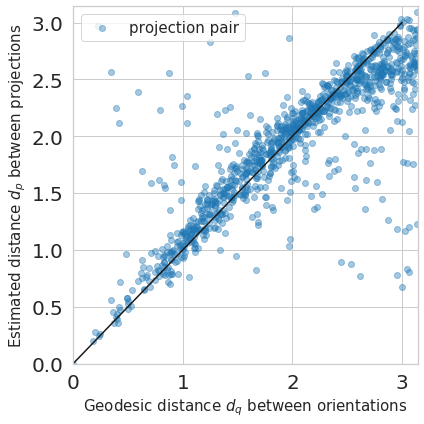

In [44]:
df1 = pd.read_csv(f"{DATA_DIR}/dP_dQ_5a1a.csv")

#plt.clf();
fig, ax = plt.subplots(figsize=(6,6));
plt.scatter(df1["d_Q"], df1["d_P"], color=TEST_COLOR_LOR, alpha=0.4, label="projection pair");  # "reg", "kde"
#sns.jointplot(x="d_Q", y="d_P", data=df1, color="b", alpha=0.3, label="projection pair", kind="kde", ax=ax[1]);  # "reg", "kde"
x = np.arange(0, np.pi);
plt.plot(x, x, color="k")
ax.set_xlim(0, np.pi)
ax.set_ylim(0, np.pi)
plt.xlabel("Geodesic distance $d_q$ between orientations", fontsize=tick_size)
plt.ylabel("Estimated distance $d_p$ between projections", fontsize=tick_size)
plt.tick_params(axis='both', which='major', labelsize=label_size)
plt.legend(loc=2, fontsize=15)
plt.tight_layout()
#plt.savefig("pdfs/dPdQ_5a1a.pdf", pad_inches=1)
plt.show();

---

## `5j0n` Distance Estimation Loss

In [45]:
tick_size = 15
label_size = 15
textbox_size=20

In [46]:
df0_train = pd.read_csv(f"{DATA_DIR}/run-noisy_var0_train-tag-epoch_loss.csv")
df0_train["noise_variance"] = df0_train.apply(lambda x: 0, axis=1)
df0_train["dataset"] = df0_train.apply(lambda x: "train", axis=1)

df0_val = pd.read_csv(f"{DATA_DIR}/run-noisy_var0_validation-tag-epoch_loss.csv")
df0_val["noise_variance"] = df0_val.apply(lambda x: 0, axis=1)
df0_val["dataset"] = df0_val.apply(lambda x: "validation", axis=1)

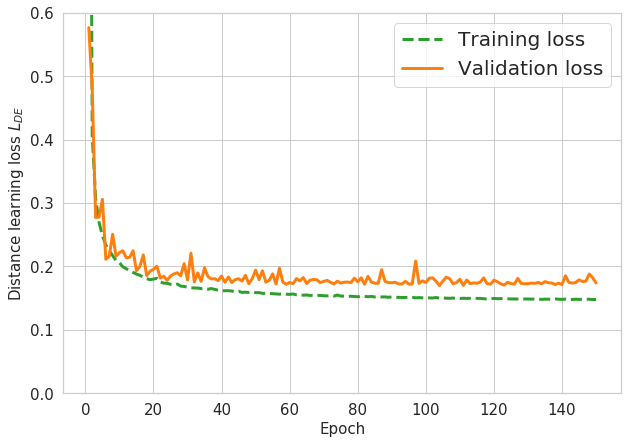

In [47]:
# Get training and test loss histories
training_loss = df0_train['Value'].values
val_loss = df0_val['Value'].values

fig, ax = plt.subplots(figsize=(10,7))

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
ax.plot(epoch_count, training_loss, c=TRAIN_COLOR, ls='--', lw=3, label='Training loss')
ax.plot(epoch_count, val_loss, c=VAL_COLOR, ls='-', lw=3, label='Validation loss')
ax.set_xlabel('Epoch', fontsize=label_size)
ax.set_ylabel('Distance learning loss $L_{DE}$', fontsize=label_size)
ax.tick_params(axis='both', which='major', labelsize=label_size)
ax.legend(loc=1, fontsize=20)
ax.set_ylim(0, 0.6)
#plt.savefig("pdfs/de_5j0n.pdf")

plt.show();

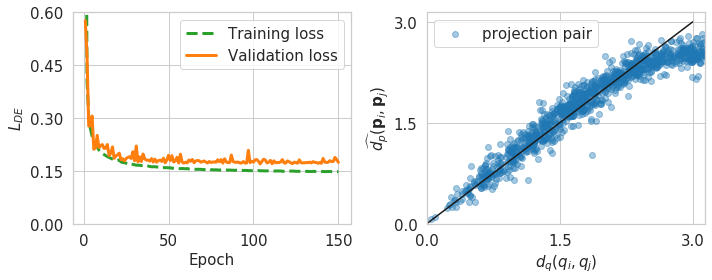

In [48]:
#fig = plt.figure(figsize=(8, 7))
#fig = plt.figure(figsize=(8.2, 3))
#fig.patch.set_facecolor('white') 
#plt.rcParams['figure.facecolor'] = 'white'
#ax1 = fig.add_axes([0, 0, 1.2, 0.8])
#ax2 = fig.add_axes([1.35, 0, 0.8, 0.8], facecolor="white")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
ax1.plot(epoch_count, training_loss, c=TRAIN_COLOR, ls='--', lw=3, label='Training loss')
ax1.plot(epoch_count, val_loss, c=VAL_COLOR, ls='-', lw=3, label='Validation loss')
ax1.set_xlabel('Epoch', fontsize=label_size)
ax1.set_ylabel('$L_{DE}$', fontsize=label_size)
ax1.tick_params(axis='both', which='major', labelsize=label_size)
ax1.legend(loc=1, fontsize=label_size)
ax1.set_ylim(0, 0.6)
ax1.xaxis.set_major_locator(plt.MaxNLocator(4))
ax1.yaxis.set_major_locator(plt.MaxNLocator(4))

####
df1 = pd.read_csv(f"{DATA_DIR}/dP_dQ_5j0n.csv")
ax2.scatter(df1["d_Q"], df1["d_P"], color=TEST_COLOR_LOR, alpha=0.4, label="projection pair");  # "reg", "kde"
#sns.jointplot(x="d_Q", y="d_P", data=df1, color="b", alpha=0.3, label="projection pair", kind="kde", ax=ax[1]);  # "reg", "kde"
x = np.arange(0, np.pi);
ax2.plot(x, x, color="k")
ax2.set_xlim(0, np.pi)
ax2.set_ylim(0, np.pi)
ax2.set_xlabel("$d_q(q_i, q_j)$", fontsize=label_size)
ax2.set_ylabel("$\widehat{d_p}(\mathbf{p}_i, \mathbf{p}_j)$", fontsize=label_size)
ax2.tick_params(axis='both', which='major', labelsize=label_size)
ax2.legend(loc=2, fontsize=label_size)
ax2.xaxis.set_major_locator(plt.MaxNLocator(3))
ax2.yaxis.set_major_locator(plt.MaxNLocator(3))

plt.tight_layout()
plt.savefig("pdfs/de_loss_dPdQ_5j0n.pdf", pad_inches=1)
plt.show();

---

In [49]:
df0_train = pd.read_csv(f"{DATA_DIR}/run-noisy_var0_5a1a_train-tag-epoch_loss.csv")
df0_train["noise_variance"] = df0_train.apply(lambda x: 0, axis=1)
df0_train["dataset"] = df0_train.apply(lambda x: "train", axis=1)

df0_val = pd.read_csv(f"{DATA_DIR}/run-noisy_var0_5a1a_validation-tag-epoch_loss.csv")
df0_val["noise_variance"] = df0_val.apply(lambda x: 0, axis=1)
df0_val["dataset"] = df0_val.apply(lambda x: "validation", axis=1)

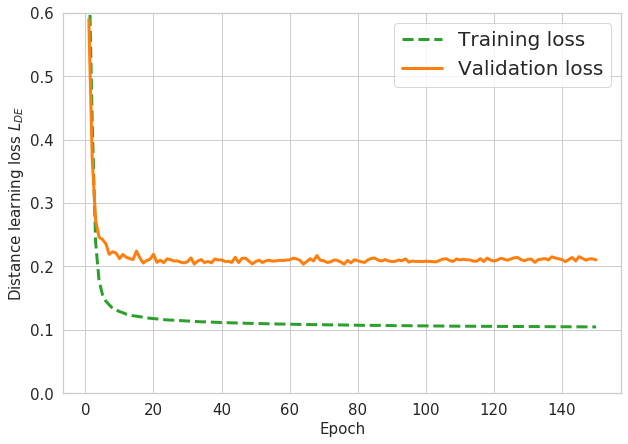

In [50]:
# Get training and test loss histories
training_loss = df0_train['Value'].values[78:228]
val_loss = df0_val['Value'].values[78:228]

fig, ax = plt.subplots(figsize=(10,7))

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
ax.plot(epoch_count, training_loss, c=TRAIN_COLOR, ls='--', lw=3, label='Training loss')
ax.plot(epoch_count, val_loss, c=VAL_COLOR, ls='-', lw=3, label='Validation loss')
ax.set_xlabel('Epoch', fontsize=label_size)
ax.set_ylabel('Distance learning loss $L_{DE}$', fontsize=label_size)
ax.tick_params(axis='both', which='major', labelsize=label_size)
ax.set_ylim(0, 0.6)
ax.legend(loc=1, fontsize=20)
#plt.savefig("pdfs/de_5a1a.pdf")
plt.show();

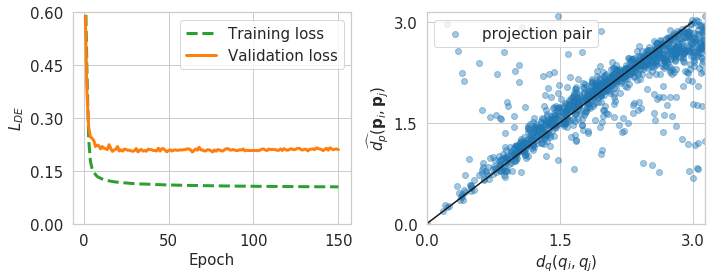

In [51]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
ax1.plot(epoch_count, training_loss, c=TRAIN_COLOR, ls='--', lw=3, label='Training loss')
ax1.plot(epoch_count, val_loss, c=VAL_COLOR, ls='-', lw=3, label='Validation loss')
ax1.set_xlabel('Epoch', fontsize=label_size)
ax1.set_ylabel('$L_{DE}$', fontsize=label_size)
ax1.tick_params(axis='both', which='major', labelsize=label_size)
ax1.legend(loc=1, fontsize=label_size)
ax1.set_ylim(0, 0.6)
ax1.xaxis.set_major_locator(plt.MaxNLocator(4))
ax1.yaxis.set_major_locator(plt.MaxNLocator(4))

####
df1 = pd.read_csv(f"{DATA_DIR}/dP_dQ_5a1a.csv")
ax2.scatter(df1["d_Q"], df1["d_P"], color=TEST_COLOR_LOR, alpha=0.4, label="projection pair");  # "reg", "kde"
#sns.jointplot(x="d_Q", y="d_P", data=df1, color="b", alpha=0.3, label="projection pair", kind="kde", ax=ax[1]);  # "reg", "kde"
x = np.arange(0, np.pi);
ax2.plot(x, x, color="k")
ax2.set_xlim(0, np.pi)
ax2.set_ylim(0, np.pi)
ax2.set_xlabel("$d_q(q_i, q_j)$", fontsize=label_size)
ax2.set_ylabel("$\widehat{d_p}(\mathbf{p}_i, \mathbf{p}_j)$", fontsize=label_size)
ax2.tick_params(axis='both', which='major', labelsize=label_size)
ax2.legend(loc=2, fontsize=label_size)
ax2.xaxis.set_major_locator(plt.MaxNLocator(3))
ax2.yaxis.set_major_locator(plt.MaxNLocator(3))

plt.tight_layout()
plt.savefig("pdfs/de_loss_dPdQ_5a1a.pdf", pad_inches=1)
plt.show();

---

In [52]:
losses_plot = np.loadtxt('5j0n_LOR_noise0.csv')
d2 = np.loadtxt('5j0n_EOR_noise0.csv')
loss_last= 0.16293360728335787

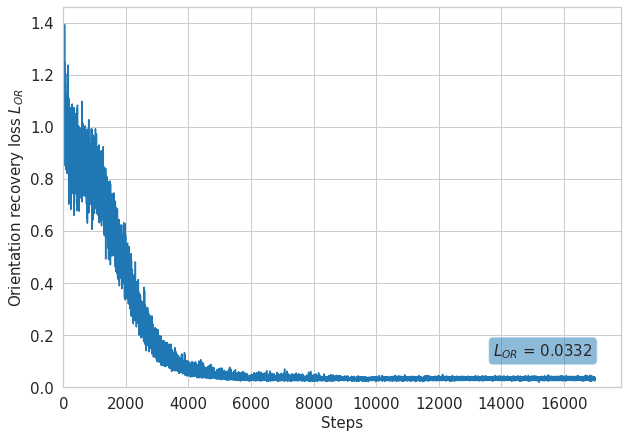

In [53]:

fig, ax = plt.subplots(figsize=(10,7))
plt.plot(losses_plot, c=TEST_COLOR_LOR) 
plt.xlabel("Steps", fontsize=tick_size)
plt.ylabel("Orientation recovery loss $L_{OR}$", fontsize=tick_size)
ax.tick_params(axis='both', which='major', labelsize=label_size)
ax.set_xlim(0)
ax.set_ylim(0)

props = dict(boxstyle='round', facecolor=TEST_COLOR_LOR, alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.77, 0.12, "$L_{OR}$ = "+f"{np.mean(losses_plot[-10:]):.4f}", transform=ax.transAxes, fontsize=15, verticalalignment='top', bbox=props)
#plt.savefig('pdfs/5j0n_noise0_angle_recovery.pdf')  
plt.show()

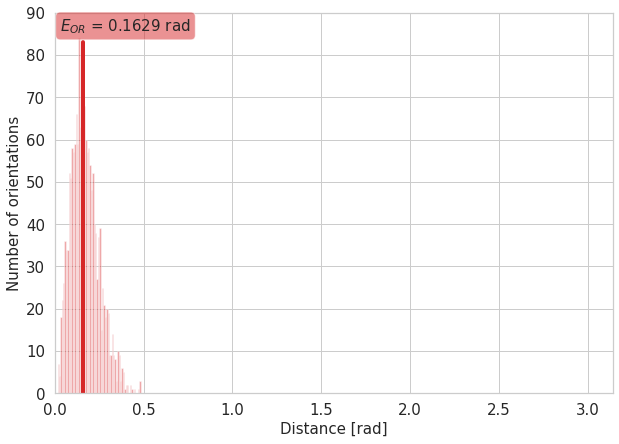

In [54]:
fig, ax = plt.subplots(figsize=(10,7))
ax.set_xlim(0, np.pi);ax.set_ylim(0, 90)
# plot histogram
s = sns.distplot(d2, kde=False, bins=60, ax=ax, color=TEST_COLOR_EOR)
max_count = int(max([h.get_height() for h in s.patches]))
# plot median line
ax.plot([np.median(d2)]*max_count, np.arange(0, max_count,1), c=TEST_COLOR_EOR, lw=4)
plt.xlabel("Distance [rad]", fontsize=tick_size)
plt.ylabel("Number of orientations", fontsize=tick_size)
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=label_size)


props = dict(boxstyle='round', facecolor=TEST_COLOR_EOR, alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.01, 0.99, "$E_{OR}$ = "+f"{loss_last:.4f} rad", transform=ax.transAxes, fontsize=15, verticalalignment='top', bbox=props)
#plt.savefig('pdfs/5j0n_noise0_angle_alignment_after.pdf')   
plt.show()

In [55]:
tick_size = 18
label_size = 20
textbox_size=20

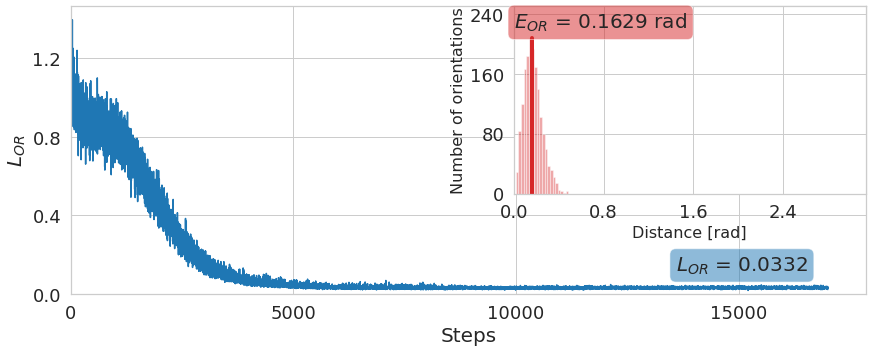

In [56]:
fig = plt.figure(figsize=(12, 5))
#fig = plt.figure(figsize=(8.2, 3))
#fig.patch.set_facecolor('white') 
#plt.rcParams['figure.facecolor'] = 'white'
ax1 = fig.add_axes([0.072, 0.17, 0.92, 0.8])
ax2 = fig.add_axes([0.585, 0.45, 0.407, 0.52], facecolor="white")

ax1.plot(losses_plot, c=TEST_COLOR_LOR) 
ax1.set_xlabel("Steps", fontsize=label_size)
ax1.set_ylabel("$L_{OR}$", fontsize=label_size)

ax1.set_xlim(0)
ax1.set_ylim(0)
#ax1.patch.set_facecolor("white")
ax1.xaxis.set_major_locator(plt.MaxNLocator(4))
ax1.yaxis.set_major_locator(plt.MaxNLocator(4))

props = dict(boxstyle='round', facecolor=TEST_COLOR_LOR, alpha=0.5)
# place a text box in upper left in axes coords
ax1.text(1.05, 0.09, "$L_{OR}$ = "+f"{np.mean(losses_plot[-10:]):.4f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props)
ax1.tick_params(axis='both', which='major', labelsize=tick_size)

### histogram
ax2.set_xlim(0, np.pi);ax2.set_ylim(0, 250)
# plot histogram
s = sns.distplot(d2, kde=False, bins=20, ax=ax2, color=TEST_COLOR_EOR)
max_count = int(max([h.get_height() for h in s.patches]))
# plot median line
ax2.plot([np.median(d2)]*max_count, np.arange(0, max_count,1), c=TEST_COLOR_EOR, lw=4)
ax2.set_xlabel("Distance [rad]", fontsize=label_size-4)
ax2.set_ylabel("Number of orientations", fontsize=label_size-4)
# We change the fontsize of minor ticks label 
props = dict(boxstyle='round', facecolor=TEST_COLOR_EOR, alpha=0.5)
# place a text box in upper left in axes coords
ax2.text(0.76, 0.73, "$E_{OR}$ = "+f"{loss_last:.4f} rad", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props)
#ax2.patch.set_facecolor("black")
#fig.patch.set_facecolor('white')
ax2.xaxis.set_major_locator(plt.MaxNLocator(4))
ax2.yaxis.set_major_locator(plt.MaxNLocator(4))
ax2.tick_params(axis='both', which='major', labelsize=tick_size)


#plt.tight_layout()
#plt.gcf().subplots_adjust(bottom=-10)
plt.savefig("pdfs/5j0n_noise0_ar_aa.pdf")
plt.show();

---

In [57]:
tick_size = 18
label_size = 20
textbox_size=20

In [58]:
losses_plot = np.loadtxt('5j0n_LOR_noise16.csv')
d2 = np.loadtxt('5j0n_EOR_noise16.csv')
loss_last= 0.4039684191404425

In [59]:
# data = np.load(f"{DATA_DIR}/angle_recovery_noisy16_limited3.14_estimated_50k.npz")
# q_predicted, losses, q_all = data["arr_0"], data["arr_1"], data["arr_2"]

# angles_predicted = quaternion2euler(q_predicted)
# angles_predicted.shape

In [60]:
# losses_plot = losses[losses>1e-5]

# fig, ax = plt.subplots(figsize=(10,7))
# plt.plot(losses_plot) # np.arange(0., 0.474*len(losses[losses>1e-5]), 0.474),
# plt.xlabel("Steps", fontsize=tick_size)
# plt.ylabel("Orientation recovery loss $L_{OR}$", fontsize=tick_size)
# ax.tick_params(axis='both', which='major', labelsize=label_size)
# ax.set_xlim(0)
# ax.set_ylim(0)

# props = dict(boxstyle='round', facecolor='b', alpha=0.5)
# # place a text box in upper left in axes coords
# ax.text(0.85, 0.14, f"{np.mean(losses_plot[-10:]):.4f}", transform=ax.transAxes, fontsize=15,
#         verticalalignment='top', bbox=props)
# #plt.savefig("pdfs/5j0n_noise16_angle_recovery.pdf")
# plt.show()

In [61]:
# np.savetxt('5j0n_LOR_noise16.csv', losses_plot)

In [62]:
# from cryoem.angle_alignment import training_angle_alignment, update_quaternion
# from tensorflow.keras.optimizers import Adagrad, Ftrl

In [63]:
# m, a_R, losses, collect_data, trajectory = training_angle_alignment(num_runs=3, 
#                                                         steps=300, 
#                                                         batch_size=256, 
#                                                         optimizer=Ftrl(learning_rate=2., learning_rate_power=-2.), 
#                                                         angles_true=np.array(angles_true)[test_idx], 
#                                                         angles_predicted=angles_predicted.numpy()[test_idx])

In [64]:
# m= [1.0, 1.0, 1.0, -1.0] 
# trajectory_first= [1.85851292, 1.43618651, 5.88178408, 3.27440446, 3.45451402, 2.50669375] 
# loss_first= 2.1299795108043504 
# trajectory_last= [  5.26063957,   7.67897047,   6.57416071,  17.74291902, -24.87016973,31.71659896] 
# loss_last= 0.4039684191404425


In [65]:
# fig, ax = plt.subplots(figsize=(10,7))
# # Distance count subplot (full)
# q_predicted_rot = update_quaternion(m, [tf.Variable(trajectory_first)], q_predicted[test_idx], dtype=tf.float64)
# d2 = d_q(q_predicted_rot, euler2quaternion(angles_true[test_idx]))
# ax.set_xlim(0, np.pi)
# ax.set_ylim(0, 115)
# #ax.set_title(f"FULL: [{step}/{steps}] Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} ({np.degrees(np.mean(d2)):.2e} deg) STD={np.std(d2):.2e}\nMEDIAN={np.median(d2):.2e} ({np.degrees(np.median(d2)):.2e} deg)")
# s = sns.distplot(d2, kde=False, bins=80, ax=ax, color="r")
# max_count = int(max([h.get_height() for h in s.patches]))
# ax.plot([np.median(d2)]*max_count, np.arange(0, max_count,1), c="r", lw=4)
# plt.xlabel("Distance [rad]", fontsize=tick_size)
# plt.ylabel("Number of orientations", fontsize=tick_size)
# # We change the fontsize of minor ticks label 
# ax.tick_params(axis='both', which='major', labelsize=label_size)


# props = dict(boxstyle='round', facecolor='r', alpha=0.5)
# # place a text box in upper left in axes coords
# ax.text(0.77, 0.72, f"$E$ = {loss_first:.4f} rad", transform=ax.transAxes, fontsize=15,
#         verticalalignment='top', bbox=props)

In [66]:
# save just the data for the plot, not the whole pipeline
# np.savetxt('5j0n_EOR_noise16.csv', d2)

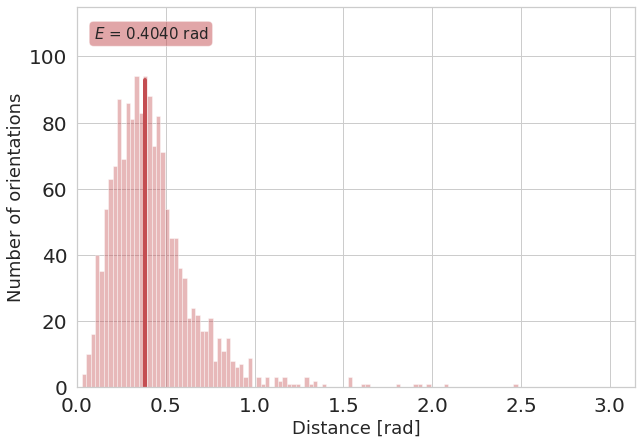

In [67]:
fig, ax = plt.subplots(figsize=(10,7))
# Distance count subplot (full)
#q_predicted_rot = update_quaternion(m, [tf.Variable(trajectory_last)], q_predicted[test_idx], dtype=tf.float64)
#d2 = d_q(q_predicted_rot, euler2quaternion(angles_true[test_idx]))
ax.set_xlim(0, np.pi)
ax.set_ylim(0, 115)
#ax.set_title(f"FULL: [{step}/{steps}] Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} ({np.degrees(np.mean(d2)):.2e} deg) STD={np.std(d2):.2e}\nMEDIAN={np.median(d2):.2e} ({np.degrees(np.median(d2)):.2e} deg)")
s = sns.distplot(d2, kde=False, bins=100, ax=ax, color="r")
max_count = int(max([h.get_height() for h in s.patches]))
ax.plot([np.median(d2)]*max_count, np.arange(0, max_count,1), c="r", lw=4)
plt.xlabel("Distance [rad]", fontsize=tick_size)
plt.ylabel("Number of orientations", fontsize=tick_size)
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=label_size)


props = dict(boxstyle='round', facecolor='r', alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.03, 0.95, f"$E$ = {loss_last:.4f} rad", transform=ax.transAxes, fontsize=15, verticalalignment='top', bbox=props)
#plt.savefig("pdfs/5j0n_noise16_angle_alignment_after.pdf")
plt.show()

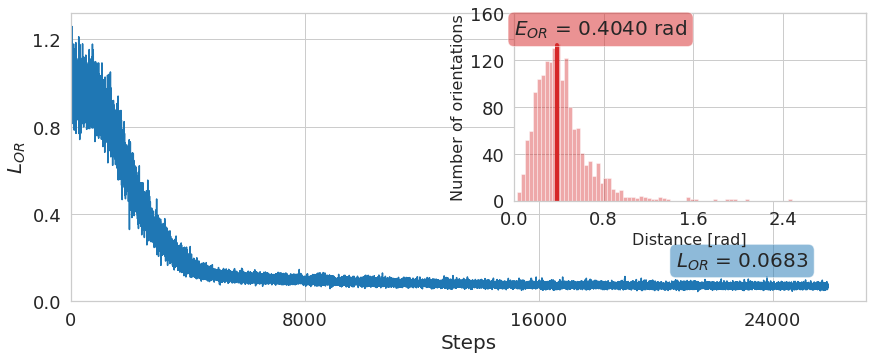

In [68]:
fig = plt.figure(figsize=(12, 5))
#fig = plt.figure(figsize=(8.2, 3))
#fig.patch.set_facecolor('white') 
#plt.rcParams['figure.facecolor'] = 'white'
ax1 = fig.add_axes([0.072, 0.17, 0.92, 0.8])
ax2 = fig.add_axes([0.585, 0.45, 0.407, 0.52], facecolor="white")

ax1.plot(losses_plot, c=TEST_COLOR_LOR) 
ax1.set_xlabel("Steps", fontsize=label_size)
ax1.set_ylabel("$L_{OR}$", fontsize=label_size)

ax1.set_xlim(0)
ax1.set_ylim(0)
#ax1.patch.set_facecolor("white")
ax1.xaxis.set_major_locator(plt.MaxNLocator(4))
ax1.yaxis.set_major_locator(plt.MaxNLocator(4))

props = dict(boxstyle='round', facecolor=TEST_COLOR_LOR, alpha=0.5)
# place a text box in upper left in axes coords
ax1.text(1.05, 0.12, "$L_{OR}$ = "+f"{np.mean(losses_plot[-10:]):.4f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props)
ax1.tick_params(axis='both', which='major', labelsize=tick_size)

### histogram
ax2.set_xlim(0, np.pi);ax2.set_ylim(0, 160)
# plot histogram
s = sns.distplot(d2, kde=False, bins=70, ax=ax2, color=TEST_COLOR_EOR)
max_count = int(max([h.get_height() for h in s.patches]))
# plot median line
ax2.plot([np.median(d2)]*max_count, np.arange(0, max_count,1), c=TEST_COLOR_EOR, lw=4)
ax2.set_xlabel("Distance [rad]", fontsize=label_size-4)
ax2.set_ylabel("Number of orientations", fontsize=label_size-4)
# We change the fontsize of minor ticks label 
props = dict(boxstyle='round', facecolor=TEST_COLOR_EOR, alpha=0.5)
# place a text box in upper left in axes coords
ax2.text(0.76, 0.73, "$E_{OR}$ = "+f"{loss_last:.4f} rad", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props)
#ax2.patch.set_facecolor("black")
#fig.patch.set_facecolor('white')
ax2.xaxis.set_major_locator(plt.MaxNLocator(4))
ax2.yaxis.set_major_locator(plt.MaxNLocator(4))
ax2.tick_params(axis='both', which='major', labelsize=tick_size)

# tightlayout does not work here
#plt.tight_layout()
plt.savefig("pdfs/5j0n_noise16_ar_aa.pdf")
plt.show();

---

## `5a1a` Orientation Recovery Loss $L_{OR}$

In [69]:
losses_plot = np.loadtxt('5a1a_LOR_noise0.csv')
d2 = np.loadtxt('5a1a_EOR_noise0.csv')
loss_last = 0.18706397562242297

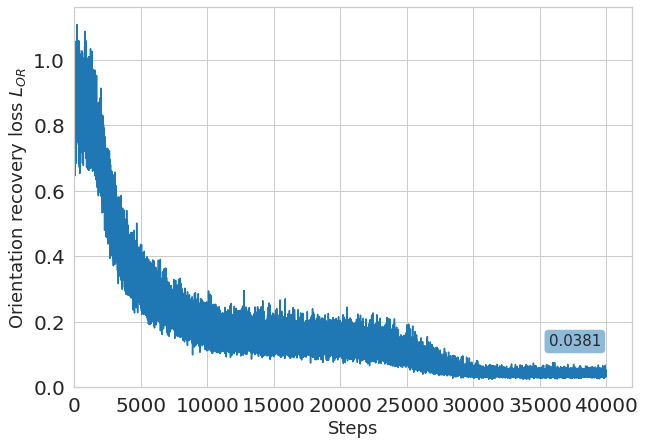

In [70]:
fig, ax = plt.subplots(figsize=(10,7))
plt.plot(losses_plot, c=TEST_COLOR_LOR) # np.arange(0., 0.474*len(losses[losses>1e-5]), 0.474),
plt.xlabel("Steps", fontsize=tick_size)
plt.ylabel("Orientation recovery loss $L_{OR}$", fontsize=tick_size)
ax.tick_params(axis='both', which='major', labelsize=label_size)
ax.set_xlim(0)
ax.set_ylim(0)

props = dict(boxstyle='round', facecolor=TEST_COLOR_LOR, alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.85, 0.14, f"{np.mean(losses_plot[-10:]):.4f}", transform=ax.transAxes, fontsize=15,
        verticalalignment='top', bbox=props)
#plt.savefig("pdfs/5a1a_noise0_angle_recovery.pdf")
plt.show()

Text(0.01, 0.99, '$E$ = 0.1871 rad')

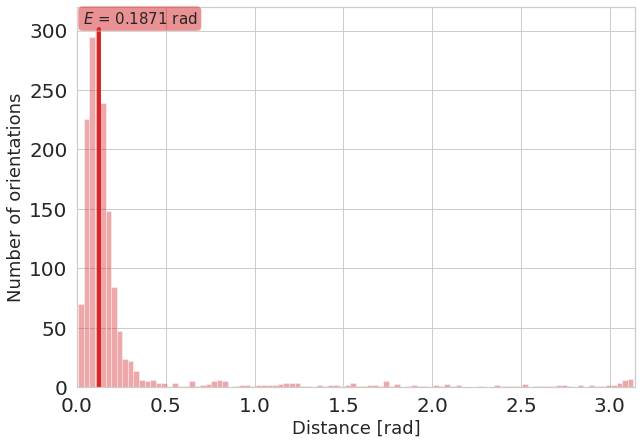

In [71]:
fig, ax = plt.subplots(figsize=(10,7))
# # Distance count subplot (full)
# q_predicted_rot = np.squeeze(update_quaternion(m, [tf.Variable(trajectory_last)], q_predicted[test_idx], dtype=tf.float64))
#d2 = d_q(q_predicted_rot, euler2quaternion(angles_true[test_idx]))
ax.set_xlim(0, np.pi)
ax.set_ylim(0, 320)
#ax.set_title(f"FULL: [{step}/{steps}] Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} ({np.degrees(np.mean(d2)):.2e} deg) STD={np.std(d2):.2e}\nMEDIAN={np.median(d2):.2e} ({np.degrees(np.median(d2)):.2e} deg)")
s = sns.distplot(d2, kde=False, bins=100, ax=ax, color=TEST_COLOR_EOR)
max_count = int(max([h.get_height() for h in s.patches]))
ax.plot([np.median(d2)]*max_count, np.arange(0, max_count,1), c=TEST_COLOR_EOR, lw=4)
plt.xlabel("Distance [rad]", fontsize=tick_size)
plt.ylabel("Number of orientations", fontsize=tick_size)
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=label_size)


props = dict(boxstyle='round', facecolor=TEST_COLOR_EOR, alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.01, 0.99, f"$E$ = {loss_last:.4f} rad", transform=ax.transAxes, fontsize=15, verticalalignment='top', bbox=props)
#plt.savefig("pdfs/5a1a_noise0_angle_alignment_after.pdf")

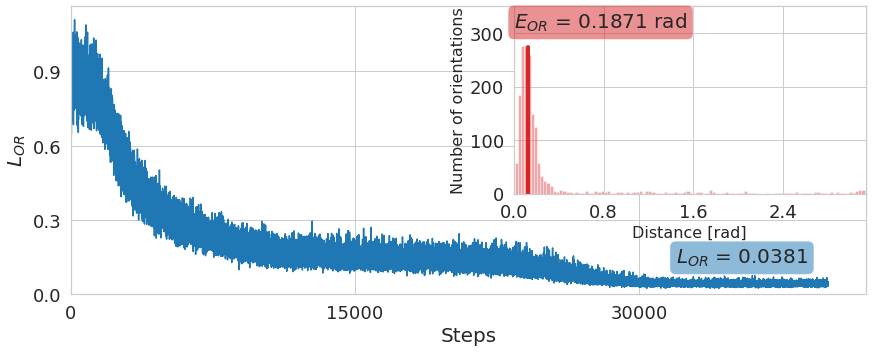

In [72]:
fig = plt.figure(figsize=(12, 5))
#fig = plt.figure(figsize=(8.2, 3))
#fig.patch.set_facecolor('white') 
#plt.rcParams['figure.facecolor'] = 'white'
ax1 = fig.add_axes([0.072, 0.17, 0.92, 0.8])
ax2 = fig.add_axes([0.585, 0.45, 0.407, 0.52], facecolor="white")

ax1.plot(losses_plot, c=TEST_COLOR_LOR) 
ax1.set_xlabel("Steps", fontsize=label_size)
ax1.set_ylabel("$L_{OR}$", fontsize=label_size)

ax1.set_xlim(0)
ax1.set_ylim(0)
#ax1.patch.set_facecolor("white")
ax1.xaxis.set_major_locator(plt.MaxNLocator(4))
ax1.yaxis.set_major_locator(plt.MaxNLocator(4))

props = dict(boxstyle='round', facecolor=TEST_COLOR_LOR, alpha=0.5)
# place a text box in upper left in axes coords
ax1.text(1.05, 0.11, "$L_{OR}$ = "+f"{np.mean(losses_plot[-10:]):.4f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props)
ax1.tick_params(axis='both', which='major', labelsize=tick_size)

### histogram
ax2.set_xlim(0, np.pi);ax2.set_ylim(0, 350)
# plot histogram
s = sns.distplot(d2, kde=False, bins=110, ax=ax2, color=TEST_COLOR_EOR)
max_count = int(max([h.get_height() for h in s.patches]))
# plot median line
ax2.plot([np.median(d2)]*max_count, np.arange(0, max_count,1), c=TEST_COLOR_EOR, lw=4)
ax2.set_xlabel("Distance [rad]", fontsize=label_size-4)
ax2.set_ylabel("Number of orientations", fontsize=label_size-4)
# We change the fontsize of minor ticks label 
props = dict(boxstyle='round', facecolor=TEST_COLOR_EOR, alpha=0.5)
# place a text box in upper left in axes coords
ax2.text(0.76, 0.73, "$E_{OR}$ = "+f"{loss_last:.4f} rad", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props)
#ax2.patch.set_facecolor("black")
#fig.patch.set_facecolor('white')
ax2.xaxis.set_major_locator(plt.MaxNLocator(4))
ax2.yaxis.set_major_locator(plt.MaxNLocator(4))
ax2.tick_params(axis='both', which='major', labelsize=tick_size)


# tightlayout does not work here
plt.savefig("pdfs/5a1a_noise0_ar_aa.pdf")
plt.show();

---

---

In [73]:
# data = np.load("1-phase1/data/5j0n/angle_recovery_limited3.14_estimated_50k_testset.npz")
# q_predicted, losses, q_all = data["arr_0"], data["arr_1"], data["arr_2"]

# angles_predicted = quaternion2euler(q_predicted)

---

## `5j0n` Projections with Perturbations

In [74]:
PROTEIN = '5j0n'
projections_filename = f"{PROTEIN}_ProjectionsAngles_ProjNber5000_AngCoverage2.0,0.4,2.0_AngShift0.0,0.0,0.0.h5"

data = h5py.File(os.path.join(DATA_DIR, projections_filename), 'r')
projections = data['Projections']
angles = data['Angles']

In [75]:
from cryoem.plots import plot_projection

In [76]:
# fg_color = 'white'
# bg_color = 'black'


In [77]:
# def _plot(image, title, ax, colorbar=False, mean=0, var=0):
#     im = ax.imshow(image)
  
#     # set title plus title color
#     ax.set_title(title, color=fg_color)

#     # set figure facecolor
#     ax.patch.set_facecolor(bg_color)

#     # set tick and ticklabel color
#     im.axes.tick_params(color=fg_color, labelcolor=fg_color)

#     # set imshow outline
#     for spine in im.axes.spines.values():
#         spine.set_edgecolor(fg_color)    

#     if colorbar:
#         cb = plt.colorbar(im)
#         # set colorbar label plus label color
#         cb.set_label('Closeness', color=fg_color)

#         # set colorbar tick color
#         cb.ax.yaxis.set_tick_params(color=fg_color)

#         # set colorbar edgecolor 
#         cb.outline.set_edgecolor(fg_color)

#         # set colorbar ticklabels
#         plt.setp(plt.getp(cb.ax.axes, 'yticklabels'), color=fg_color)

In [78]:

# def plot_projection(projection, angles, fg_color = 'white', bg_color = 'black', colorbar=True):
#     # NOTE: used
#     projection = np.squeeze(projection)

#     fig, ax = plt.subplots(1, 1, figsize=(7, 7))
    
#     _plot(projection, f"Angles: {', '.join([f'{x:.2f}' for x in angles])} [rad]", ax, colorbar=True)

#     fig.patch.set_facecolor(bg_color) 
#     plt.tight_layout()
#     plt.show()

In [79]:
from cryoem.preprocessing import preprocessing

In [80]:
_projections = preprocessing(projections, rescale_dim=116, noise_var_scale=0, left_limit=0, peak_limit=0, right_limit=0, channels=1, dtype=np.float32)

<class 'numpy.float64'>
Preprocessing projections
	Noise:
		No noise
	Translation:
		No translation
	Image rescaled: 
		from dimension 116 to 116
	Global standardization
		Image shape: (116, 116)
		Data Type: float64
		Mean: 0.262 | Std: 1.046
		Min:  0.000 | Max: 15.458
		Mean: 0.000 | Std: 1.000
		Min:  -0.250 | Max: 14.526
<class 'numpy.float32'>
<class 'numpy.float32'>


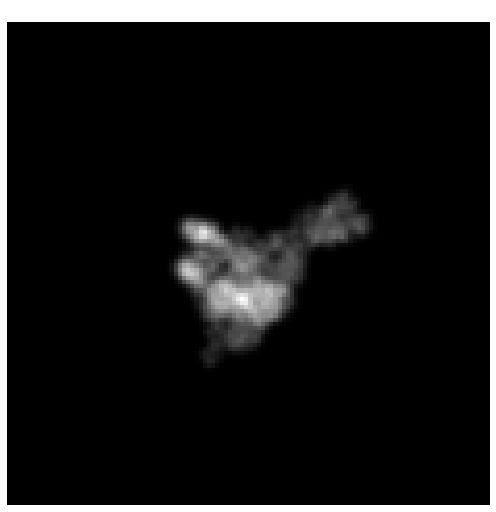

In [81]:
plot_projection(projection=_projections[1], angles=angles[1], bg_color='white', colorbar=False)

In [82]:
_projections = preprocessing(projections, rescale_dim=116, noise_var_scale=16, left_limit=0, peak_limit=0, right_limit=0, channels=1, dtype=np.float32)

<class 'numpy.float64'>
Preprocessing projections
	Noise:
		Variance= 247.32705688476562
	Translation:
		No translation
	Image rescaled: 
		from dimension 116 to 116
	Global standardization
		Image shape: (116, 116)
		Data Type: float64
		Mean: 0.262 | Std: 15.762
		Min:  -85.951 | Max: 87.593
		Mean: 0.000 | Std: 1.000
		Min:  -5.470 | Max: 5.541
<class 'numpy.float32'>
<class 'numpy.float32'>


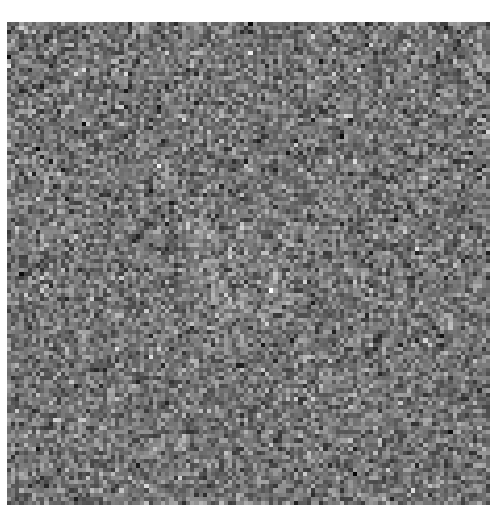

In [83]:
plot_projection(projection=_projections[1], angles=angles[1], bg_color='white', colorbar=False)

In [84]:
_projections = preprocessing(projections, rescale_dim=116, noise_var_scale=0, left_limit=-30, peak_limit=-30, right_limit=0, channels=1, dtype=np.float32)

<class 'numpy.float64'>
Preprocessing projections
	Noise:
		No noise
	Translation:
		left_limit=-30, peak_limit=-30, right_limit=0
	Image rescaled: 
		from dimension 116 to 116
	Global standardization
		Image shape: (116, 116)
		Data Type: float64
		Mean: 0.262 | Std: 1.046
		Min:  0.000 | Max: 15.458
		Mean: 0.000 | Std: 1.000
		Min:  -0.250 | Max: 14.526
<class 'numpy.float32'>
<class 'numpy.float32'>


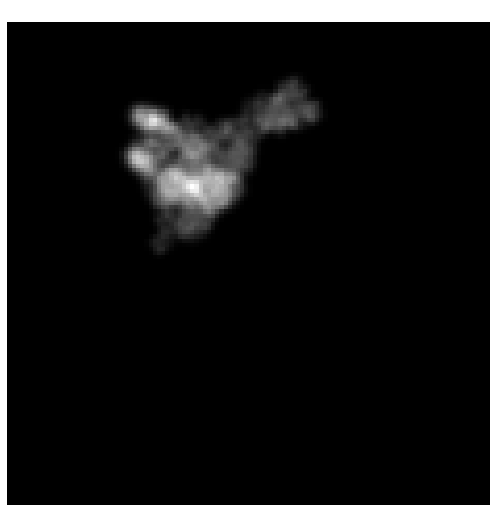

In [85]:
plot_projection(projection=_projections[1], angles=angles[1], bg_color='white', colorbar=False)

In [86]:
_projections = preprocessing(projections, rescale_dim=116, noise_var_scale=16, left_limit=-30, peak_limit=-30, right_limit=0, channels=1, dtype=np.float32)

<class 'numpy.float64'>
Preprocessing projections
	Noise:
		Variance= 247.32705688476562
	Translation:
		left_limit=-30, peak_limit=-30, right_limit=0
	Image rescaled: 
		from dimension 116 to 116
	Global standardization
		Image shape: (116, 116)
		Data Type: float64
		Mean: 0.264 | Std: 15.762
		Min:  -87.285 | Max: 88.037
		Mean: 0.000 | Std: 1.000
		Min:  -5.555 | Max: 5.569
<class 'numpy.float32'>
<class 'numpy.float32'>


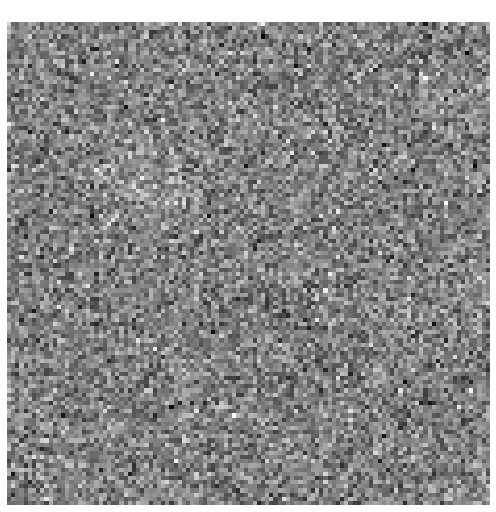

In [87]:
plot_projection(projection=_projections[1], angles=angles[1], bg_color='white', colorbar=False)